In [1]:
def reproduceResult():
  seed_value= 0

  
  with tf.device("/gpu:0"):
    ...


  os.environ['PYTHONHASHSEED']=str(seed_value)
  np.random.seed(0)
  rn.seed(0)


  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                          inter_op_parallelism_threads=1)


  tf.compat.v1.set_random_seed(seed_value)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.compat.v1.keras.backend.clear_session()

  


In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import os 
import numpy as np
import tensorflow as tf
import random as rn
from tensorflow import keras

reproduceResult()
# %tensorflow_version 2.x
# import tensorflow as tf
# tf.test.gpu_device_name()
# from scipy import integrate
# import os
# import numpy as np
# from tensorflow import keras
import tempfile
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K


from tensorflow.keras import callbacks

from keras_lr_finder import LRFinder
from clr.clr_callback import CyclicLR

import tensorflow_model_optimization as tfmot

import tqdm

import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from attention import Attention

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math


from keras.preprocessing.text import Tokenizer


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

from bnlp import SentencepieceTokenizer
import gensim
import fasttext 

C:\Users\moshi\AppData\Local\Temp\ipykernel_2276\2832172220.py:43: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
df_train = pd.read_excel('F:/Context_Aware_Data_Cleaning_Deep/EMONOBA/Dataset/emonoba_train_clean.xlsx')
df_test = pd.read_excel('F:/Context_Aware_Data_Cleaning_Deep/EMONOBA/Dataset/emonoba_val_clean.xlsx')

In [4]:
df_train.head

<bound method NDFrame.head of                                                     Data  Love  Joy  Surprise  \
0                                লকাল বাস ভালো এটা থেকে      0    0         0   
1       কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ...     0    0         0   
2       বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬...     0    0         0   
3                      চাচাজি তো কেবল মাকে ধর্ষণ করেছেন      0    0         0   
4                              সত্যিকার মানুষ তারাই ভাই      0    1         0   
...                                                  ...   ...  ...       ...   
18415   সমস্যা নাই কি আমরা একদিন ক্রিকেট কে শাসন করবে...     0    1         0   
18416   খানকিরপুলা তার মাকে গিয়ে বলে তর মাকে মনটা গিয়ে।      0    0         0   
18417                                     ভাই চেয়ার কই🙄      0    0         1   
18418                         সবকয়টা তো একই গোয়ালের গাই      0    0         0   
18419   বসন্তের ফুলেল উপহার তো পেলাম না' রওশন: আছে আছ...     0    0         0  

In [5]:
# Function to get the emotion with value 1 or NaN if all values are 0
def get_emotion(row):
    emotions = ['Love', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Fear']
    nonzero_emotions = [emotion for emotion in emotions if row[emotion] == 1]
    return nonzero_emotions[0] if nonzero_emotions else np.nan

# Create a new column 'Emotion' based on the custom function
df_train['Label'] = df_train.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_train = df_train[['Data', 'Label']]

In [6]:
# Create a new column 'Emotion' based on the custom function
df_test['Label'] = df_test.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_test = df_test[['Data', 'Label']]

In [7]:
df_train.isnull()

,Data,Label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
18415,False,False
18416,False,False
18417,False,False
18418,False,False


In [8]:
df_train.dropna(inplace=True)

In [9]:
df_train.groupby("Label").describe()

Data                                                               
         count unique                                                top freq
Label                                                                        
Anger     3295   3293   এই অফিসে প্রয়োজনের তুলনায় কর্মী বেশি। কর্মী ছ...    2
Fear       162    162                          যদি গড় গ্রেড সি চলে আসে     1
Joy       6478   6449                                     খুব ভালো লাগল     5
Love      3786   3776                                    ছুঁয়ে দিলে মন     2
Sadness   3975   3974   কে সে? নিশ্চয়ই শয়তান জামাল! : না : তা হলে নিশ...    2
Surprise   724    724   তাদের প্রায় ইডিট কোটি ব্যবহারকারী অ্যাকাউন্ট ...    1

In [10]:
df_train["Label"].value_counts()

Joy         6478
Sadness     3975
Love        3786
Anger       3295
Surprise     724
Fear         162
Name: Label, dtype: int64

In [11]:
# train, test = train_test_split(df, test_size=0.2, stratify = df["classes"], random_state = 42)
num_classes = 6
embed_num_dims = 300
max_seq_len = 50

x_train = df_train['Data']
x_test = df_test['Data']

y_train = df_train['Label']
y_test = df_test['Label']

texts_train = x_train
texts_test = x_test

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Data'])

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len, padding='pre' )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len,  padding='pre')

print(X_train_pad)

encoding = {
    "Love":0,
    "Joy":1,
    "Sadness":2,
    "Anger":3,
    "Fear":4,
    "Surprise":5
}

y_train = [encoding[x] for x in df_train['Label']]
y_test = [encoding[x] for x in df_test['Label']]



y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


Number of unique words: 26317
[[    0     0     0 ...     3    54    17]
 [    0     0     0 ...     9     2    56]
 [    0     0     0 ...     6 10841 10842]
 ...
 [    0     0     0 ...     1  2120 26314]
 [    0     0     0 ...   593 26316  3795]
 [    0     0     0 ...    40    18    40]]


In [12]:
# META EMBADDING

In [13]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open('F:/Python_code/embedding/cc.bn.300.vec',encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix


embedd_matrix_fasttext = create_embedding_matrix(index_of_words, embed_num_dims)
print(embedd_matrix_fasttext.shape)

(26318, 300)


# Random Search

In [14]:
from tensorflow.keras import regularizers
import time
LOG_DIR = f"{int(time.time())}"
seed_value= 0



def build_model(hp):
  
  reproduceResult()

  print('Ya it comes here')
  fake_val = hp.Int("cnn_1_unit",min_value =16, max_value = 96, step = 16)
  cnn_1_unit = hp.Int("cnn_1_unit",min_value =16, max_value = 96, step = 16)
  cnn_1_dropout = hp.Float("cnn_1_dropout",min_value = 0.1,max_value = 0.3,step = 0.1)

  lstm_unit = hp.Int("lstm_unit",min_value =64, max_value = 256, step = 32)
  lstm_dropout = hp.Float("lstm_dropout",min_value = 0.1,max_value = 0.5,step = 0.1)




  seq_input = keras.layers.Input(shape=(max_seq_len,))

  embedded = keras.layers.Embedding(vocab_size,
                          embed_num_dims,
                          input_length = max_seq_len,
                          weights = [embedd_matrix_fasttext])(seq_input)

  cnn = keras.layers.Conv1D(cnn_1_unit,3,kernel_regularizer=regularizers.l2(1e-4),
                            bias_regularizer=regularizers.l2(1e-2),
                            activity_regularizer=regularizers.l2(1e-4))(embedded)
  cnn = keras.layers.Activation(activation='relu')(cnn)
  cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.Dropout(cnn_1_dropout,seed=seed_value)(cnn)

  lstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_unit, recurrent_regularizer=regularizers.l2(1e-4),
                                                      return_sequences=True,kernel_regularizer=regularizers.l2(1e-4),
                                                      bias_regularizer=regularizers.l2(1e-2),
                                                      activity_regularizer=regularizers.l2(1e-4),input_shape =(48,)))(cnn)
  lstm = keras.layers.Activation(activation='relu')(lstm)
  lstm = keras.layers.BatchNormalization()(lstm)
  lstm = keras.layers.Dropout(lstm_dropout,seed=seed_value)(lstm)
  
  
  max_pooling = keras.layers.GlobalMaxPooling1D()(lstm)
  output = keras.layers.Dense(num_classes, activation='softmax')(max_pooling)

  model = keras.Model(inputs = [seq_input], outputs = output)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model


stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True,
                              verbose=0, mode='max')


clr_step_size = int((len(X_train_pad)/64))
base_lr = 1e-3
max_lr = 6e-3
mode = 'exp_range'


clr = CyclicLR(base_lr = base_lr, max_lr = max_lr, step_size = clr_step_size, mode = mode)



tuner = RandomSearch(
    build_model,
    objective = keras_tuner.Objective('val_accuracy', direction="max"),
    max_trials = 30,
    executions_per_trial = 1,
    directory = LOG_DIR
    )
  
tuner.search(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))


tuner.results_summary()

Trial 30 Complete [00h 00m 47s]
val_accuracy: 0.5510503053665161

Best val_accuracy So Far: 0.5803614854812622
Total elapsed time: 00h 27m 51s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1708718317\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
cnn_1_unit: 64
cnn_1_dropout: 0.1
lstm_unit: 128
lstm_dropout: 0.1
Score: 0.5803614854812622

Trial 22 summary
Hyperparameters:
cnn_1_unit: 32
cnn_1_dropout: 0.1
lstm_unit: 128
lstm_dropout: 0.5
Score: 0.5798729658126831

Trial 01 summary
Hyperparameters:
cnn_1_unit: 16
cnn_1_dropout: 0.2
lstm_unit: 256
lstm_dropout: 0.30000000000000004
Score: 0.5788959264755249

Trial 11 summary
Hyperparameters:
cnn_1_unit: 48
cnn_1_dropout: 0.1
lstm_unit: 256
lstm_dropout: 0.5
Score: 0.5749877691268921

Trial 09 summary
Hyperparameters:
cnn_1_unit: 16
cnn_1_dropout: 0.1
lstm_unit: 160
lstm_dropout: 0.5
Score: 0.5705910921096802

Trial 12 summary
Hyperparameters:
cn

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_1_unit (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
cnn_1_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
lstm_unit (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [16]:
#get best hypoerparamter
best_hps = tuner.get_best_hyperparameters()[0]
model = build_model(best_hps)

Ya it comes here


In [17]:
history = model.fit(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))

Epoch 1/30
288/288 [==============================] - 9s 23ms/step - loss: 2.8545 - accuracy: 0.4837 - val_loss: 2.0450 - val_accuracy: 0.2145
Epoch 2/30
288/288 [==============================] - 6s 21ms/step - loss: 0.9610 - accuracy: 0.7086 - val_loss: 1.2341 - val_accuracy: 0.5608
Epoch 3/30
288/288 [==============================] - 6s 21ms/step - loss: 0.5243 - accuracy: 0.8508 - val_loss: 2.3620 - val_accuracy: 0.4040
Epoch 4/30
288/288 [==============================] - 6s 21ms/step - loss: 0.5721 - accuracy: 0.8403 - val_loss: 1.6476 - val_accuracy: 0.5491
Epoch 5/30
288/288 [==============================] - 6s 21ms/step - loss: 0.3278 - accuracy: 0.9250 - val_loss: 2.3128 - val_accuracy: 0.4724
Epoch 6/30
288/288 [==============================] - 6s 21ms/step - loss: 0.4107 - accuracy: 0.9003 - val_loss: 1.9819 - val_accuracy: 0.5486
Epoch 7/30
288/288 [==============================] - 6s 21ms/step - loss: 0.2827 - accuracy: 0.9428 - val_loss: 2.7348 - val_accuracy: 0.5051

In [18]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

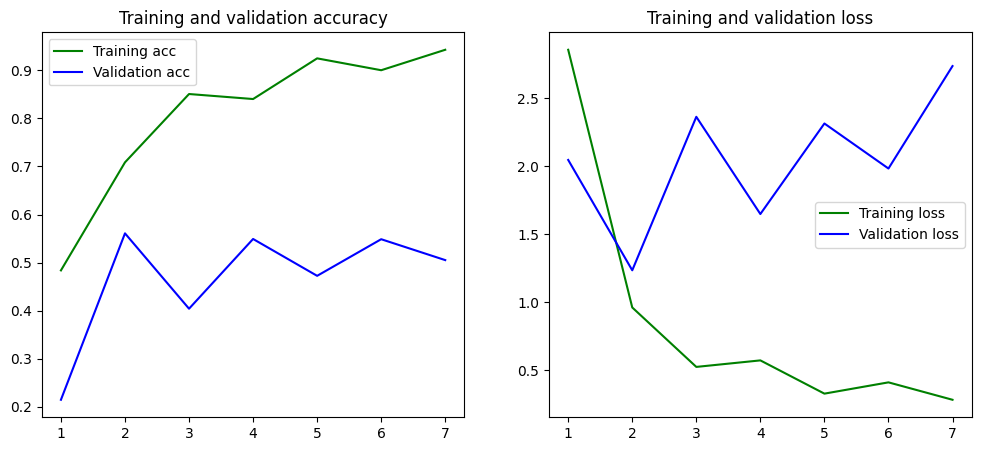

In [19]:
PlotGraph(history)

In [20]:
predict = model.predict(X_test_pad)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

64/64 [==============================] - 1s 6ms/step


array([1, 3, 1, ..., 1, 2, 3], dtype=int64)

In [21]:
predict_lables=np.argmax(y_test, axis=1)
predict_lables

array([1, 3, 1, ..., 1, 2, 3], dtype=int64)

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predict_lables, predict_class)
cm

array([[227, 131,  17,  27,   0,  12],
       [174, 430,  64,  43,   2,  30],
       [ 14,  46, 295,  45,   4,  25],
       [ 45,  44,  68, 164,  10,  31],
       [  2,   3,   4,   8,   0,   3],
       [  5,  10,  18,  14,   0,  32]], dtype=int64)

In [23]:
class_names = list(encoding.keys())

In [24]:
print(class_names)

['Love', 'Joy', 'Sadness', 'Anger', 'Fear', 'Surprise']


<Axes: >

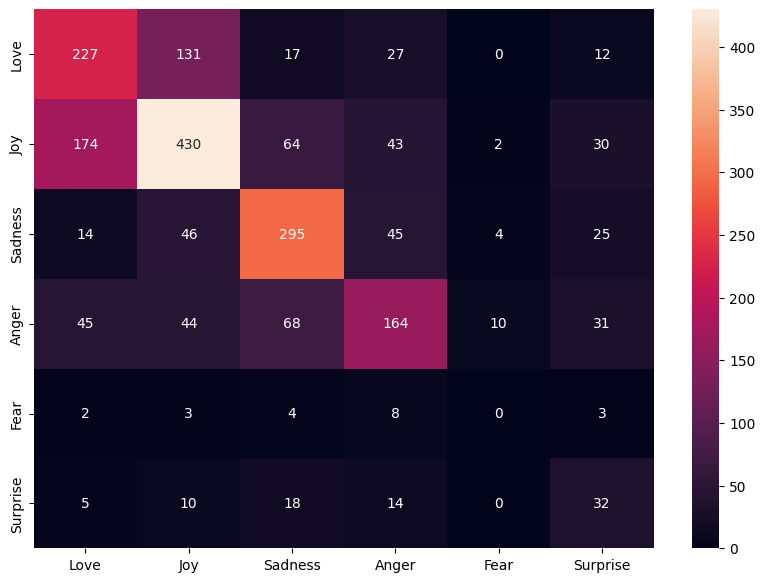

In [25]:
df_cm = pd.DataFrame(cm, index=class_names,columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [26]:
from sklearn.metrics import classification_report
print(classification_report(predict_lables, predict_class, target_names =class_names))

              precision    recall  f1-score   support

        Love       0.49      0.55      0.52       414
         Joy       0.65      0.58      0.61       743
     Sadness       0.63      0.69      0.66       429
       Anger       0.54      0.45      0.49       362
        Fear       0.00      0.00      0.00        20
    Surprise       0.24      0.41      0.30        79

    accuracy                           0.56      2047
   macro avg       0.43      0.45      0.43      2047
weighted avg       0.57      0.56      0.56      2047

